## Observations and Insights 

In [1]:
#Observations:

#1. Female / Male mouse subjects were roughly evenly divided
#2. A positive correlation exists between tumor size and weight of test subject
#3. The Ramicane treatment plan results in the smallest average tumor size across all drug regimens tested

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import linregress

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path  = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results  = pd.read_csv(study_results_path)

##############################################################################
#                                                                            #
#  Findings: 1 - many relationship between mouse metadata and study results  #
#  Left join on mouse to include all test subjects to study results          #  
#                                                                            #
##############################################################################

mouse_df         = pd.DataFrame(mouse_metadata)
study_results_df = pd.DataFrame(study_results)

mouse_df.columns         # Index(['Mouse ID', 'Drug Regimen', 'Sex', 'Age_months', 'Weight (g)'], dtype='object')
study_results_df.columns # Index(['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites'], dtype='object')

# Combine the data into a single dataset.  
merged_results_df = pd.merge(mouse_df, study_results_df, how="outer", on=["Mouse ID", "Mouse ID"])

# Display the data table for preview
merged_results_df.head(15)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
5,k403,Ramicane,Male,21,16,25,33.464577,1
6,k403,Ramicane,Male,21,16,30,31.099498,1
7,k403,Ramicane,Male,21,16,35,26.546993,1
8,k403,Ramicane,Male,21,16,40,24.365505,1
9,k403,Ramicane,Male,21,16,45,22.050126,1


In [3]:
# Checking the number of mice.
series_count = merged_results_df["Mouse ID"].unique()
print(f"Number of mice (subjects) = {len(series_count)}")

Number of mice (subjects) = 249


In [4]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint.

#Source: https://stackoverflow.com/questions/63888720/issue-while-using-loc-with-in-keyword
duplicate_ids  = merged_results_df[merged_results_df.duplicated(["Mouse ID", "Timepoint"])]["Mouse ID"].unique()
dupe_id_series =  merged_results_df.loc[(merged_results_df["Mouse ID"].isin(duplicate_ids))]
duplicated_mouse_id =  (pd.DataFrame(dupe_id_series)["Mouse ID"]).unique()[0]

print(f"Duplicated Mouse ID is '{duplicated_mouse_id}'")

Duplicated Mouse ID is 'g989'


In [5]:
# Optional: Get all the data for the duplicate mouse ID. 

duplicated_mouse_records_df = merged_results_df.loc[merged_results_df["Mouse ID"] == duplicated_mouse_id]
duplicated_mouse_records_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [6]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
dedupped_df = merged_results_df.loc[merged_results_df["Mouse ID"] != duplicated_mouse_id]

In [7]:
# Checking the number of mice in the clean DataFrame
mouse_count = len(dedupped_df["Mouse ID"].unique())
print(f"The du-dupped mouse count is {mouse_count}")

The du-dupped mouse count is 248


## Summary Statistics

In [8]:
#Part 1:
# Generate a summary statistics table consisting of the mean, median, variance, standard deviation, 
# and SEM of the tumor volume for each drug regimen.  Use groupby and summary statistical methods to 
# calculate the following properties of each drug regimen:

mean_series     = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].mean()
median_series   = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].median()
variance_series = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].var()
std_series      = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].std()
sem_series      = dedupped_df.groupby(["Drug Regimen"])["Tumor Volume (mm3)"].sem()

# Assemble the resulting series into a single summary dataframe.

series_dictionary = {"Mean" : mean_series,
                     "Median" : median_series,
                     "Variance" : variance_series,
                     "Std Dev": std_series,
                     "SEM" : sem_series}

summary_df  = pd.DataFrame(series_dictionary)

#Appropriatley Format columns
summary_df["Mean"]     = summary_df["Mean"].map("{:.2f}".format)
summary_df["Median"]   = summary_df["Median"].map("{:.2f}".format)
summary_df["Variance"] = summary_df["Variance"].map("{:.2f}".format)
summary_df["StdDev"]   = summary_df["Std Dev"].map("{:.2f}".format) 
summary_df["SEM"]      = summary_df["SEM"].map("{:.2f}".format)

#Display Visualization
summary_df

,Mean,Median,Variance,Std Dev,SEM,StdDev
Drug Regimen,,,,,,
Capomulin,40.68,41.56,24.95,4.994774,0.33,4.99
Ceftamin,52.59,51.78,39.29,6.268188,0.47,6.27
Infubinol,52.88,51.82,43.13,6.567243,0.49,6.57
Ketapril,55.24,53.70,68.55,8.279709,0.60,8.28
Naftisol,54.33,52.51,66.17,8.134708,0.60,8.13
Placebo,54.03,52.29,61.17,7.821003,0.58,7.82
Propriva,52.32,50.45,43.85,6.622085,0.54,6.62
Ramicane,40.22,40.67,23.49,4.846308,0.32,4.85
Stelasyn,54.23,52.43,59.45,7.710419,0.57,7.71


In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
# Using the aggregation method, produce the same summary statistics in a single line

#Source: https://stackoverflow.com/questions/19078325/naming-returned-columns-in-pandas-aggregate-function

#Reset the index for DataFrame re-use
dedupped_df.reset_index()

#1-line group-by/aggregation function
summary_df = dedupped_df.groupby(["Drug Regimen"]).agg(Mean=("Tumor Volume (mm3)",'mean'),
                                                       Median=("Tumor Volume (mm3)",'median'),
                                                       Variance=("Tumor Volume (mm3)",'var'),
                                                       StdDev=("Tumor Volume (mm3)",'std'),
                                                       SEM=("Tumor Volume (mm3)",'std'))
#Appropriatley Format columns
summary_df["Mean"]     = summary_df["Mean"].map("{:.2f}".format)
summary_df["Median"]   = summary_df["Median"].map("{:.2f}".format)
summary_df["Variance"] = summary_df["Variance"].map("{:.2f}".format)
summary_df["StdDev"]   = summary_df["StdDev"].map("{:.2f}".format) 
summary_df["SEM"]      = summary_df["SEM"].map("{:.2f}".format)

#Display Visualization
summary_df

,Mean,Median,Variance,StdDev,SEM
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,4.99
Ceftamin,52.59,51.78,39.29,6.27,6.27
Infubinol,52.88,51.82,43.13,6.57,6.57
Ketapril,55.24,53.70,68.55,8.28,8.28
Naftisol,54.33,52.51,66.17,8.13,8.13
Placebo,54.03,52.29,61.17,7.82,7.82
Propriva,52.32,50.45,43.85,6.62,6.62
Ramicane,40.22,40.67,23.49,4.85,4.85
Stelasyn,54.23,52.43,59.45,7.71,7.71


## Bar and Pie Charts

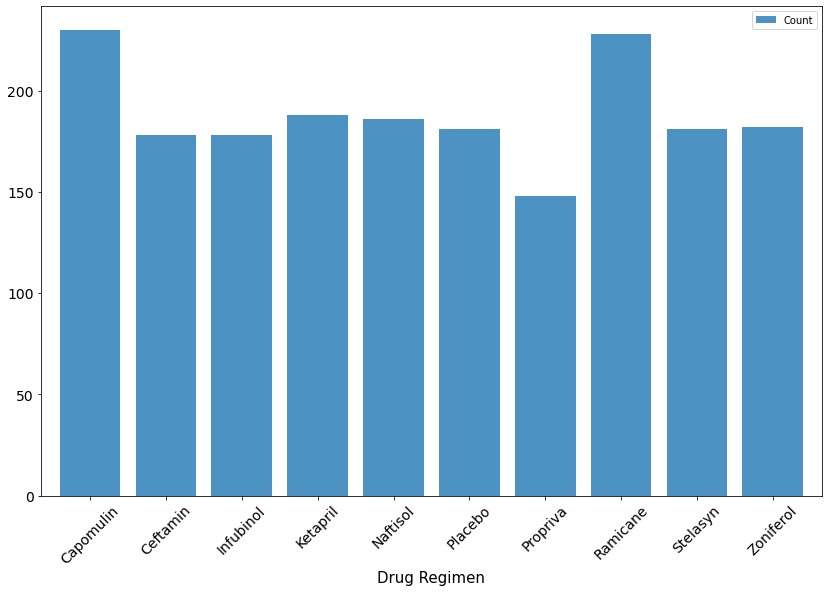

In [10]:
#Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.

chart = dedupped_df.groupby(["Drug Regimen"])["Mouse ID"].count()                         \
                                                 .reset_index()                           \
                                                 .rename(columns={"Mouse ID": "Count"})   \
                                                 .plot                                    \
                                                 .bar(x="Drug Regimen",                   \
                                                      y="Count",                          \
                                                      rot=45,                             \
                                                      figsize=(14,9),                     \
                                                      fontsize=14,                        \
                                                      alpha=.8,                           \
                                                      width=0.8) 

#Sourece: https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib
chart.xaxis.label.set_size(15)


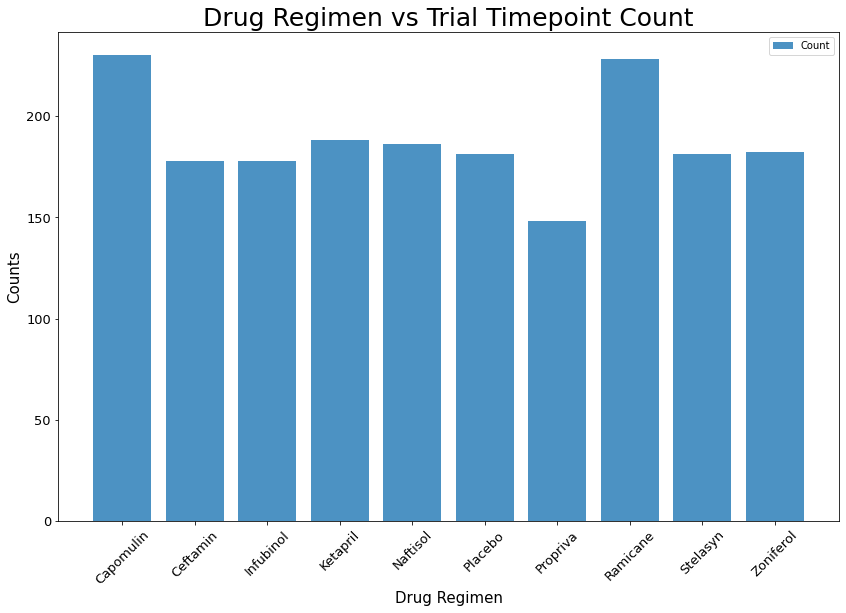

In [11]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.

df = dedupped_df.groupby(["Drug Regimen"])["Mouse ID"].count().reset_index().rename(columns={"Mouse ID": "Count"})

drugs  = list(df["Drug Regimen"])
counts = list(df["Count"])

plt.subplots(figsize=(14, 9))
plt.bar(drugs, counts, align='center',alpha=.8, label='Count',width=0.8)

plt.title('Drug Regimen vs Trial Timepoint Count', fontsize = 25)
plt.xlabel('Drug Regimen',fontsize = 15)
plt.ylabel('Counts', fontsize = 15)
plt.xticks(fontsize=13, rotation=45)

plt.legend()

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

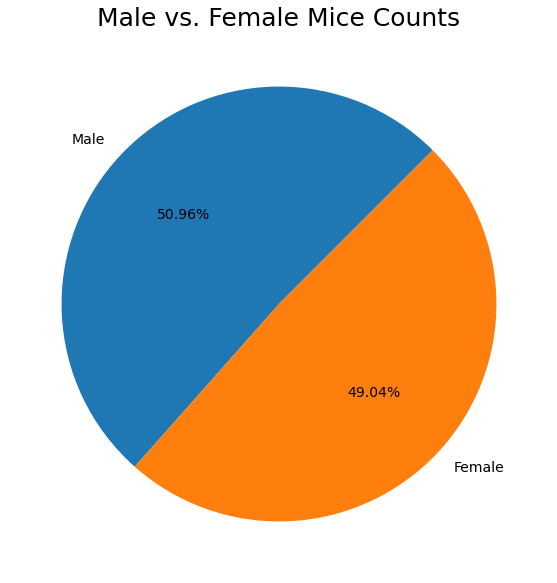

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas

#Source: https://stackoverflow.com/questions/63687789/how-do-i-create-a-pie-chart-using-categorical-data-in-matplotlib

chart = dedupped_df['Sex'].value_counts().plot(kind='pie', 
                                               autopct='%.2f%%',
                                               figsize=(15, 10),
                                               fontsize=14,
                                               title="Male vs. Female Mice Counts",
                                               startangle=45)
chart.axes.title.set_size(25)
chart = chart.yaxis.set_label_text("")




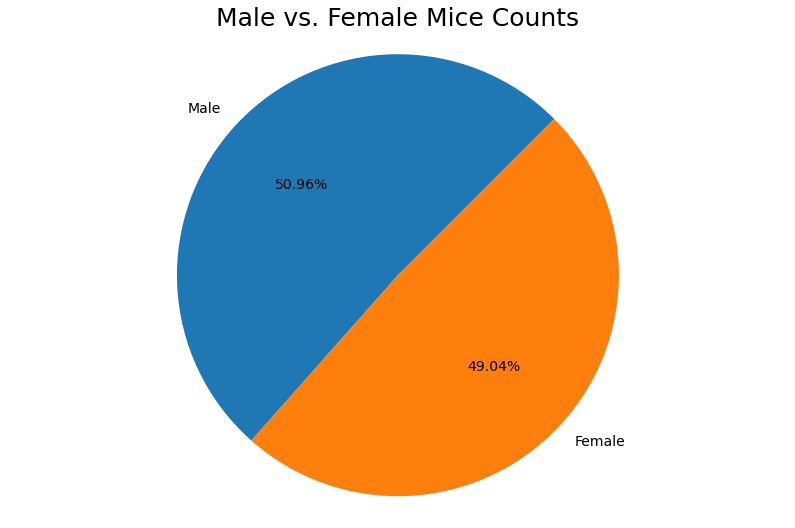

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

#Source: https://stackoverflow.com/questions/7082345/how-to-set-the-labels-size-on-a-pie-chart-in-python

explode = (0,0)

df = pd.DataFrame(dedupped_df['Sex'].value_counts()).reset_index().rename(columns={"index":"Gender","Sex":"Count"})

labels = list(df["Gender"].unique())
counts = list(df["Count"].unique())

plt.subplots(figsize=(14, 9))

plt.pie(counts, 
        explode, 
        labels, 
        autopct='%1.2f%%',
        startangle=45,
        textprops={'fontsize': 14})

plt.title("Male vs. Female Mice Counts", fontsize = 25)
plt.axis('equal')
plt.show()

## Quartiles, Outliers and Boxplots

In [14]:
#Calculate the final tumor volume of each mouse across four of the most promising treatment regimens: 
#Capomulin, Ramicane, Infubinol, and Ceftamin. Calculate the quartiles and IQR and quantitatively determine 
#if there are any potential outliers across all four treatment regimens.

# Start by getting the last (greatest) timepoint for each mouse

unfiltered_df  = dedupped_df.groupby(["Drug Regimen", "Mouse ID"])["Timepoint"].max().reset_index()
unfiltered_df

,Drug Regimen,Mouse ID,Timepoint
0,Capomulin,b128,45
1,Capomulin,b742,45
2,Capomulin,f966,20
3,Capomulin,g288,45
4,Capomulin,g316,45
...,...,...,...
243,Zoniferol,q633,45
244,Zoniferol,s337,45
245,Zoniferol,w140,5
246,Zoniferol,w575,45


In [15]:
# Merge this group df with the original dataframe to get the tumor volume at the last timepoint

merged_max_tv_results_df = pd.merge(unfiltered_df, study_results_df, how="left", on=["Mouse ID","Timepoint"])   
merged_max_tv_results_df = merged_max_tv_results_df[["Mouse ID","Drug Regimen","Timepoint","Tumor Volume (mm3)"]]
merged_max_tv_results_df


,Mouse ID,Drug Regimen,Timepoint,Tumor Volume (mm3)
0,b128,Capomulin,45,38.982878
1,b742,Capomulin,45,38.939633
2,f966,Capomulin,20,30.485985
3,g288,Capomulin,45,37.074024
4,g316,Capomulin,45,40.159220
...,...,...,...,...
243,q633,Zoniferol,45,70.827796
244,s337,Zoniferol,45,62.109651
245,w140,Zoniferol,5,47.717952
246,w575,Zoniferol,45,68.401286


In [16]:
# Put treatments into a list for 'for loop' (and later for plot labels)

filtered_treatments = ["Capomulin", "Ramicane", "Infubinol", "Ceftamin"]

# Create empty list to fill with tumor vol data (for plotting)

tumor_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

tumor_vol_label = "Tumor Volume (mm3)"

# Locate the rows which contain mice on each drug and get the tumor volumes
for filtered_treatment in filtered_treatments:
    
    regimine_df = merged_max_tv_results_df.loc[merged_max_tv_results_df["Drug Regimen"] == filtered_treatment][["Mouse ID","Timepoint","Tumor Volume (mm3)"]].set_index("Mouse ID")
    print("\n")
    print(f"Data for ***{filtered_treatment.upper()}***",end="\n\n")
    print(regimine_df)
    
    tumor_data.append({filtered_treatment:regimine_df}) #Add the subset

    quartiles = regimine_df[tumor_vol_label].quantile([.25,.5,.75]) #Across all de-duped data
    lowerq    = quartiles[0.25]
    upperq    = quartiles[0.75]
    iqr       = upperq-lowerq
    
    print("\n")   
    print(f"The lower quartile of '{tumor_vol_label}' is: {lowerq}")
    print(f"The upper quartile of '{tumor_vol_label}'  is: {upperq}")
    print(f"The interquartile range of '{tumor_vol_label}'  is: {iqr}")
    print(f"The the median of '{tumor_vol_label}'  is: {quartiles[0.5]}")

    # Determine outliers using upper and lower bounds
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    
    print(f"Values below {lower_bound} could be outliers")
    print(f"Values above {upper_bound} could be outliers")    




Data for ***CAPOMULIN***

          Timepoint  Tumor Volume (mm3)
Mouse ID                               
b128             45           38.982878
b742             45           38.939633
f966             20           30.485985
g288             45           37.074024
g316             45           40.159220
i557             45           47.685963
i738             45           37.311846
j119             45           38.125164
j246             35           38.753265
l509             45           41.483008
l897             45           38.846876
m601             45           28.430964
m957             45           33.329098
r157             15           46.539206
r554             45           32.377357
r944             45           41.581521
s185             45           23.343598
s710             45           40.728578
t565             45           34.455298
u364             45           31.023923
v923             45           40.658124
w150             10           39.952347
w914        

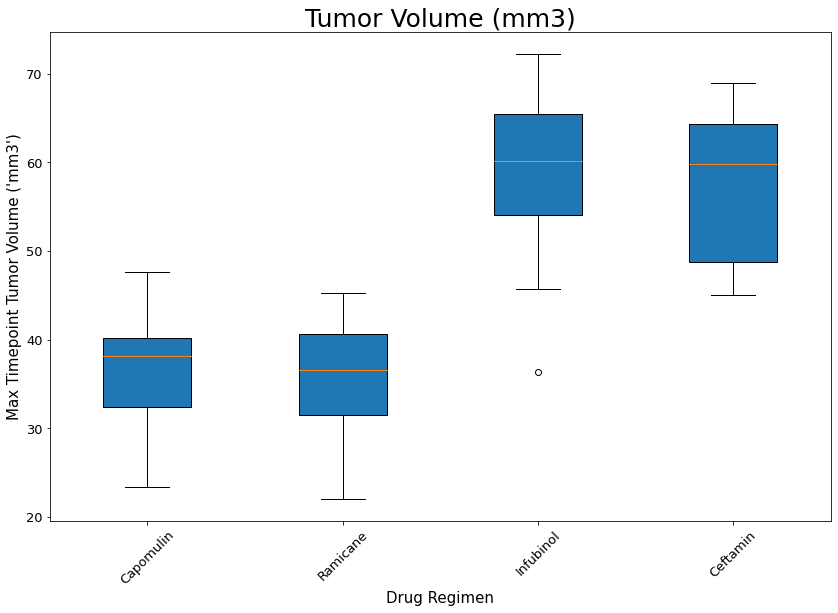

In [17]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

#tumor_data 

regimine1 = list(tumor_data[0][list(tumor_data[0].keys())[0]][tumor_vol_label])
regimine2 = list(tumor_data[1][list(tumor_data[1].keys())[0]][tumor_vol_label])
regimine3 = list(tumor_data[2][list(tumor_data[2].keys())[0]][tumor_vol_label])
regimine4 = list(tumor_data[3][list(tumor_data[3].keys())[0]][tumor_vol_label])

data_container = [regimine1,regimine2,regimine3,regimine4]

#Source: https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller

plt.subplots(figsize=(14, 9))
plt.title('Tumor Volume (mm3)',fontsize = 25)
plt.ylabel('Max Timepoint Tumor Volume (\'mm3\')',fontsize = 15)
plt.xlabel('Drug Regimen',fontsize = 15)
plt.boxplot(data_container, labels=filtered_treatments, patch_artist=True)

plt.xticks(fontsize=13,rotation=45)
plt.yticks(fontsize=13)

plt.show()

## Line and Scatter Plots

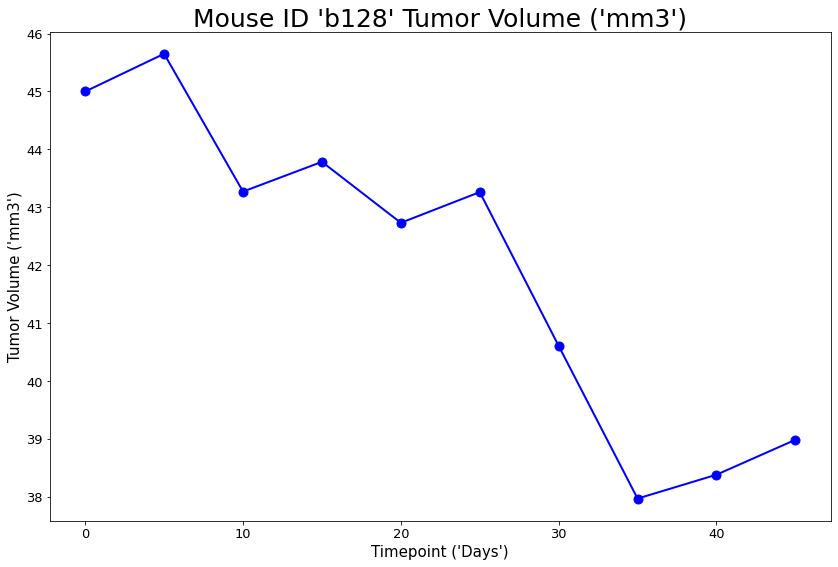

In [21]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin
# Select a mouse that was treated with Capomulin and generate a line plot of tumor volume 
# vs. time point for that mouse.

mouse_x = dedupped_df.loc[dedupped_df["Drug Regimen"] == "Capomulin"]["Mouse ID"].min()

x_values = list(dedupped_df.loc[dedupped_df["Mouse ID"] == mouse_x]["Timepoint"])
y_values = list(dedupped_df.loc[dedupped_df["Mouse ID"] == mouse_x]["Tumor Volume (mm3)"])

plt.subplots(figsize=(14, 9))
plt.plot(x_values, y_values,linewidth=2, color="blue", marker="o", markersize=9)

plt.title(f"Mouse ID '{mouse_x}' Tumor Volume (\'mm3\')", fontsize = 25)
plt.xlabel('Timepoint (\'Days\')',  fontsize = 15)
plt.ylabel('Tumor Volume (\'mm3\')',fontsize = 15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

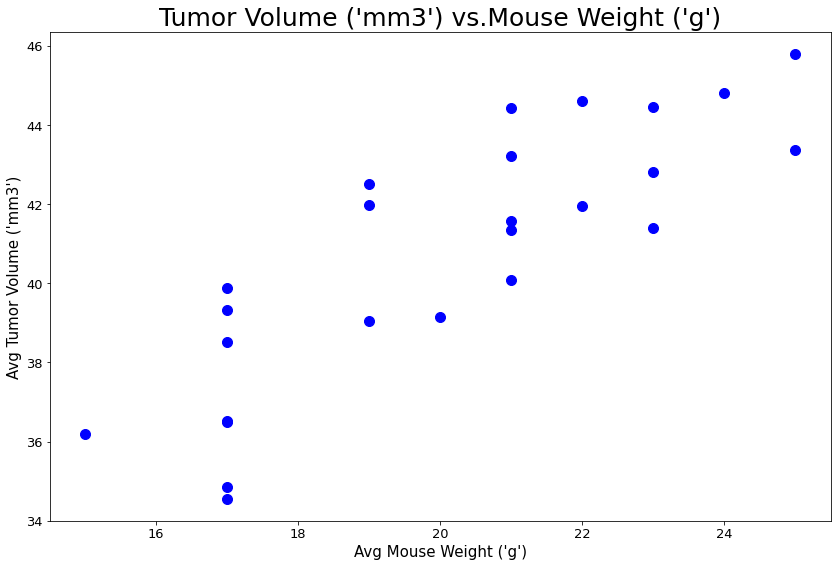

In [22]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen

avg_capm_vol = dedupped_df.loc[dedupped_df["Drug Regimen"] == "Capomulin"]            \
                          .groupby(['Mouse ID'])[["Weight (g)","Tumor Volume (mm3)"]] \
                          .mean().reset_index()

avg_weights   = avg_capm_vol["Weight (g)"]
avg_tumor_vol = avg_capm_vol["Tumor Volume (mm3)"]

plt.subplots(figsize=(14, 9))
plt.scatter(avg_weights, avg_tumor_vol, s=100, color="blue")

plt.title('Tumor Volume (\'mm3\') vs.Mouse Weight (\'g\')',fontsize = 25)
plt.xlabel('Avg Mouse Weight (\'g\')',   fontsize = 15)
plt.ylabel('Avg Tumor Volume (\'mm3\')', fontsize = 15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

## Correlation and Regression

In [ ]:
#Plot the linear regression model on top of the previous scatter plot.

regress_values = avg_weights * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
fig1, ax1 = plt.subplots(figsize=(14, 9))
plt.scatter(avg_weights, avg_tumor_vol, s=80, color="blue")
plt.plot(avg_weights, regress_values,"r-")
plt.annotate(line_eq, (21, 35), fontsize=25, color="red")
plt.title('Avg Mouse Weight (\'g\') vs. Avg Tumor Volume (\'mm3\')',fontsize = 23)
plt.xlabel('Average Mouse Weight (\'g\')',  fontsize = 15)
plt.ylabel('Average Tumor Volume (\'mm3\')',fontsize = 15)


plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()